## Signal Processing

Signal processing is an electrical engineering subfield that focuses on analyzing, modifying and synthesizing signals, such as sound, images, potential fields, seismic signals, altimetry processing, and scientific measurements [ [Discrete-Time Signal Processing](https://www.pearson.com/en-us/subject-catalog/p/discrete-time-signal-processing/P200000003226/9780137549771)]. Signal processing techniques are used to optimize transmissions, digital storage efficiency, correcting distorted signals, subjective video quality and to also detect or pinpoint components of interest in a measured signal [ [IEEE Signal Processing](https://signalprocessingsociety.org/our-story/signal-processing-101)].

Examples of sampled signals include:
- Speech and Audio Processing
- Speech Recognition
- Hearing Aids
- Autonomous Driving
- Image Processing and Analysis
- and Communications Systems and Networds

### Sampling
**Sampling** is the peice of a continuous-time signal to a discrete-time signal.

### Sampling Interval
**Sampling interval** is the distnace between points at which measurements are taken or the time elapses between two measurements. 


### Noise
**Noise** is a general term for unwanted or unknown signal that is captured during storage, transmission, or processing, and conversion.

In [24]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa
import IPython.display

#### Example of a noisy data 
Here the noisy data is created by adding noise at $dt = 10$ with different values. Let's see without removing the data how can we smooth this out?

(-0.1, 1.1)

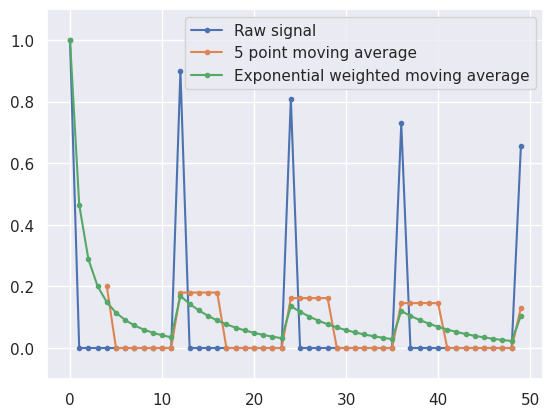

In [48]:
x = np.zeros(50)

noise = 1
for i in np.linspace(0, 49, 5):
    #print(i, noise)
    x[int(i)] = noise
    noise -= noise/10
    
plt.plot(x, '.-', label='Raw signal')
plt.plot(pd.Series(x).rolling(5).mean(), '.-', label='5 point moving average')
plt.plot(pd.Series(x).ewm(halflife=5).mean(), '.-', label='Exponential weighted moving average')
plt.legend()
plt.ylim(-0.1, 1.1)



### Analyzing Audio Files

For this purpose I want to use **librosa** library which is pretty handy in signal processing. The data source is from this [link](https://xeno-canto.org/59137/download'), which is a bird sound. The audio file is loaded as $wav$ file and the sampling frequency is set: 44000 per second (44 kHz).

In [155]:
import urllib.request

url = 'https://xeno-canto.org/59137/download'
audio_file = urllib.request.urlretrieve(url, './data/star_wars.wav')

y, sr = librosa.load('./data/star_wars.wav', sr = 44000)

/home/mn/python-environments/env/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


In [142]:
print(f'fs: {sr}, \n\nmono:\n{y[0:100]}')

fs: 44000, 

mono:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [156]:
IPython.display.Audio(data=y, rate=sr)

Text(0.5, 1.0, 'Bird Sound')

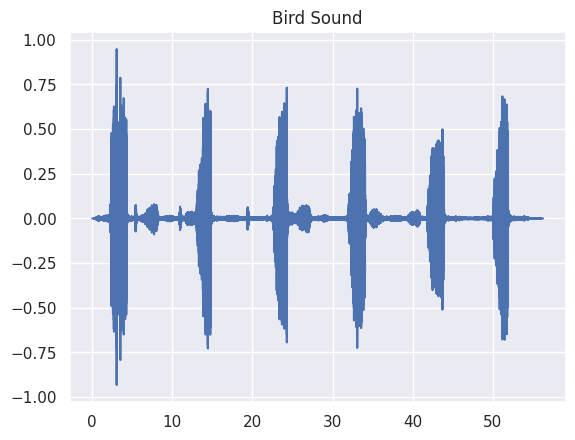

In [157]:
T = len(y)/sr
t = np.linspace(0,T, len(y)) # reconstructed timestamps

plt.plot(t,y)
plt.title("Bird Sound")

Text(0.5, 1.0, 'Zoom: 2.5 ms')

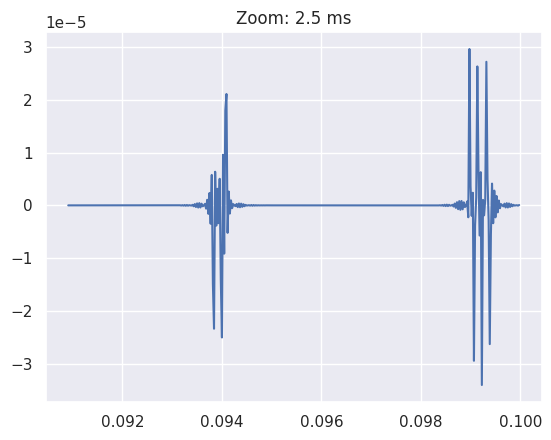

In [145]:
ts = pd.Series(y[4000:4400], index = t[4000:4400])

ts.plot()
plt.title("Zoom: 2.5 ms")

### Low Pass Filters
These filters pass signals with a frequency lower than a selected cutoff frequency and blocks the ones are higher than cutoff frequency.
In python there low pass filter which can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html)

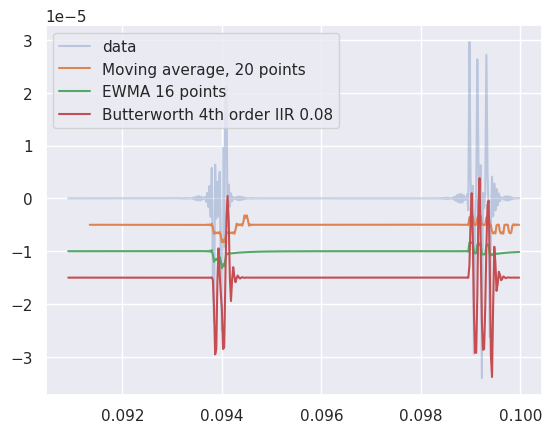

In [146]:
from scipy.signal import butter, lfilter

delta = 5*10**-6

ax = pd.DataFrame(ts).plot(alpha = 0.3)
(pd.DataFrame(ts).rolling(20).mean() - delta).plot(alpha = 1.0, ax=ax)
(pd.Series(ts).ewm(16).mean() - 2*delta).plot(alpha = 1.0, ax=ax)
# Second argument to butter is the cut-off frequency, in units of the Nyquist frequency
pd.Series(data = lfilter(*butter(4, 0.5, 'low'), x = ts.values) - 3*delta,
          index = ts.index).plot(alpha = 1.0, ax=ax)
plt.legend(['data', 'Moving average, 20 points',
            'EWMA 16 points', 'Butterworth 4th order IIR 0.08'])

Now applying low pass filter and we will see how the frequency is cut.

In [148]:
mono_filtered = lfilter(*butter(1, 0.00008, 'low'), x = y)
print("Cutoff: %f Hz" % (0.08 * 44100 / 2))
IPython.display.Audio(data=np.hstack([y[0:44100*3], mono_filtered[0:44100*3]]), rate=sr)

Cutoff: 1764.000000 Hz


### Frequency Domain
The frequency domain refers to a mathematical analysis of varibales which are dependent on time. For example consider different signals with different frequencies. The frequency domain can quantify the signals amplitudes as function of frequencies. 

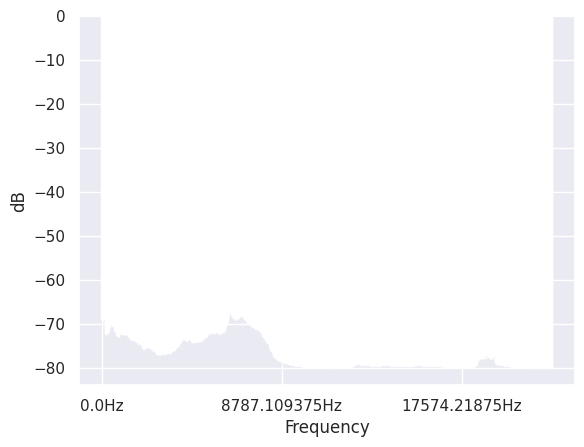

In [149]:
n_fft = 2048
S = librosa.stft(y, n_fft=n_fft, hop_length=n_fft//2)
# convert to db
# (for your CNN you might want to skip this and rather ensure zero mean and unit variance)
D = librosa.amplitude_to_db(np.abs(S), ref=np.max)
# average over file
D_AVG = np.mean(D, axis=1)

plt.bar(np.arange(D_AVG.shape[0]), D_AVG)
x_ticks_positions = [n for n in range(0, n_fft // 2, n_fft // 5)]
x_ticks_labels = [str(fs / 2048 * n) + 'Hz' for n in x_ticks_positions]
plt.xticks(x_ticks_positions, x_ticks_labels)
plt.xlabel('Frequency')
plt.ylabel('dB')
plt.show()


### Spectrograms
A [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) is a visual representation of the spectrum of frequencies as it vaires in time. 
How to calculate the **Spectrograms**? 
1. Devide the signal into equal lentgh segments and the length should be short enough that the signal doesn't change too much in each segment.
1. Calculate the short time Fourier transform of each segment.  
1. Finaly calculate the power of each spectrum in each segments and display them with colormap. 

As an example below the spectrum of original frequency and the filtered one is plotted side by side. 

/home/mn/python-environments/env/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7726: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


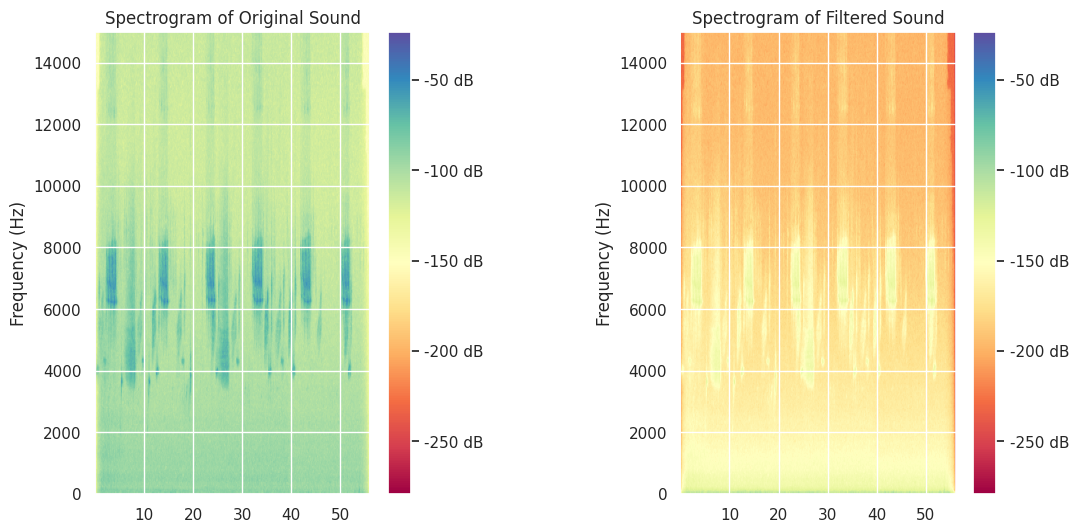

In [150]:
plt.figure(figsize=(12, 6))
plt.subplots_adjust(wspace=0.7)
plt.subplot(121)
_, _, _, im = plt.specgram(y, Fs=44100, NFFT=1024, cmap=plt.get_cmap('Spectral'))
plt.ylim(0,15000)
plt.title("Spectrogram of Original Sound")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format='%+2.0f dB')

plt.subplot(122)
_ = plt.specgram(mono_filtered, Fs=44100, NFFT=1024, cmap=plt.get_cmap('Spectral'), 
                 vmin=im.get_clim()[0], vmax=im.get_clim()[1])
plt.ylim(0,15000)
plt.title("Spectrogram of Filtered Sound")
plt.ylabel("Frequency (Hz)")
plt.colorbar(format='%+2.0f dB')

### Mel-Frequency Scale
Presents the short term power spectrum of sound [link](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum). 

Let's look at the siren from an ambulance:

The spectrogram above was calculated with an FFT window of 2048 points, corresponding to roughly 46.5ms. This means that the lowest frequency we can analyze is ~21.5Hz, which corresponds to the lowest sound frequencies audible to the human ear.

We can distinguish a main frequency and 5+ harmonics.

Librosa allows to calculate and display the Mel-spectrogram:

Text(0.5, 1.0, '2. Easier to see what is happening with only 10 mels.')

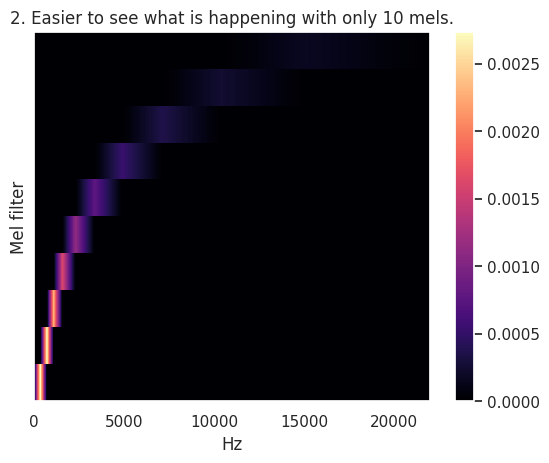

In [151]:
mel_10 = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=10)
librosa.display.specshow(mel_10, sr=sr, hop_length=n_fft+1, x_axis='linear')
plt.ylabel('Mel filter')
plt.colorbar()
plt.title('2. Easier to see what is happening with only 10 mels.')

To calculate the **Mel-Frequency** coefficients (MFCC) I use the availbale library in **librosa** [source code](https://librosa.org/doc/main/generated/librosa.feature.mfcc.html)

/home/mn/python-environments/env/lib/python3.10/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


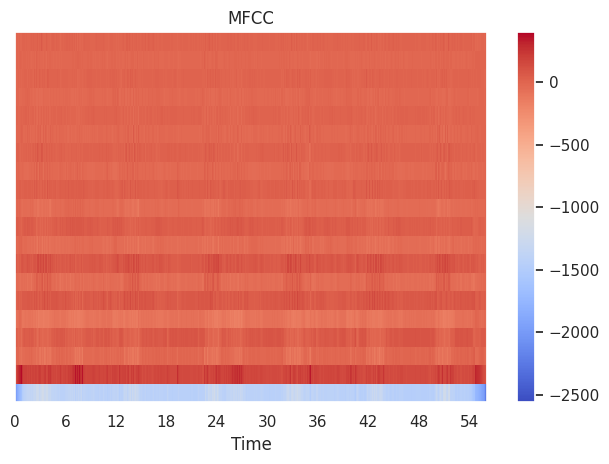

In [152]:
mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S, ref=np.max), sr=sr)
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()